## Conversational RAG

In [24]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich
from datetime import datetime


from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")
WS_API_TOKEN = os.getenv("WS_API_TOKEN")

In [22]:
import json

from typing import List, Optional
from haystack.utils import Secret
from haystack import Pipeline, component, Document
from haystack.components.builders import PromptBuilder
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.routers import ConditionalRouter
from haystack.components.websearch.serper_dev import SerperDevWebSearch 

from haystack import Pipeline
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator
from haystack.evaluation import EvaluationRunResult



In [3]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever


In [4]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [5]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy

In [6]:
from haystack.components.converters import OutputAdapter

In [18]:
@component
class QueryExpander:

    def __init__(self, open_ai_key: str , prompt: Optional[str] = None, model: str = "gpt-4o-mini"):

        self.query_expansion_prompt = prompt
        self.model = model
        self.open_ai_key = open_ai_key
        if prompt == None:
          self.query_expansion_prompt = """
          You are part of an information system that processes users queries.
          You expand a given query into {{ number }} queries that are similar in meaning.

          Structure:
          Follow the structure shown below in examples to generate expanded queries.
          The idea is to obtain as output a string containing a list with {{ number }} queries.

          Examples:
          Query: "climate change effects"
          Output: ["impact of climate change", "consequences of global warming", "effects of environmental changes"]

          Query: ""machine learning algorithms""
          Output: ["neural networks", "clustering", "supervised learning", "deep learning"]

          Query: "renewable energy sources"
          Output: ["solar power", "wind energy", "hydropower", "benefits of renewable energy", "green energy technologies"]

          Query: "mental health in adolescents"
          Output: ["teen depression", "anxiety in teenagers", "mental health support for youth", "effects of social media on mental health", "counseling for adolescents"]

          Query: "cybersecurity risks"
          Output: ["data breaches", "phishing attacks", "network security threats", "cybersecurity best practices", "malware protection"]

          Your Task:
          Query: "{{query}}"
          Output:
          """
        builder = PromptBuilder(self.query_expansion_prompt)
        llm = OpenAIGenerator(model = self.model, api_key = self.open_ai_key)
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(queries=List[str])
    def run(self, query: str, number: int = 5):
        result = self.pipeline.run({'builder': {'query': query, 'number': number}})
        expanded_query = json.loads(result['llm']['replies'][0]) + [query]
        
        return {"queries": list(expanded_query)}

In [8]:
@component
class MultiQueryElasticsearchEmbeddingRetriever:

    def __init__(self, retriever: ElasticsearchEmbeddingRetriever,  top_k: int = 3):
        self.retriever = retriever
        self.embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
        self.results = []
        self.ids = set()
        self.top_k = top_k

        self.pipeline = Pipeline()
        self.pipeline.add_component(name="embedder", instance=self.embedder)
        self.pipeline.add_component(name="retriever", instance=self.retriever)
        self.pipeline.connect("embedder", "retriever")
        

    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query in queries:
          result = self.pipeline.run({"embedder": {'text':query}, "retriever": {"top_k": self.top_k}})
          for doc in result['retriever']['documents']:
            self.add_document(doc)
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"documents": self.results}

In [9]:
system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. 

If the answer is not contained within the documents, reply with 'no_answer'.

    Conversation history:
    {% for memory in memories %}
        {{ memory.content }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

user_message = ChatMessage.from_user(user_message_template)

In [10]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        If the answer is not contained within the documents, reply with 'no_answer'.

        Conversation history:
        {% for memory in memories %}
            {{ memory.content }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [11]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch", 
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

In [12]:
system_message_for_web = ChatMessage.from_system("""You are a helpful AI assistant using provided supporting documents from web to assist humans""")

prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

prompt_for_websearch = ChatMessage.from_user(prompt_for_websearch)

In [13]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


chat_agent = Pipeline()
chat_agent.add_component("expander", QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
chat_agent.add_component("query_rephrase_llm", OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))
chat_agent.add_component("retriever", MultiQueryElasticsearchEmbeddingRetriever(retriever=ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)))
chat_agent.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
chat_agent.add_component("generator", chat_generator)
chat_agent.add_component("router", ConditionalRouter(routes=routes))
chat_agent.add_component("websearch", SerperDevWebSearch(api_key=Secret.from_token(WS_API_TOKEN))) 
chat_agent.add_component("prompt_builder_for_websearch", ChatPromptBuilder(variables=["query", "documents"], required_variables=["query", "documents"]))
chat_agent.add_component("llm_for_websearch",  OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))


chat_agent.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
chat_agent.connect("query_rephrase_llm.replies", "list_to_str_adapter")
chat_agent.connect("list_to_str_adapter.output", "expander")
chat_agent.connect("expander.queries", "retriever.queries")
chat_agent.connect("retriever.documents", "prompt_builder.documents")
chat_agent.connect("prompt_builder.prompt", "generator.messages")
chat_agent.connect("generator.replies", "router.replies")
chat_agent.connect("router.go_to_websearch", "websearch.query")
chat_agent.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
chat_agent.connect("websearch.documents", "prompt_builder_for_websearch.documents")
chat_agent.connect("prompt_builder_for_websearch.prompt", "llm_for_websearch.messages")




🚅 Components
  - expander: QueryExpander
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: MultiQueryElasticsearchEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
  - router: ConditionalRouter
  - websearch: SerperDevWebSearch
  - prompt_builder_for_websearch: ChatPromptBuilder
  - llm_for_websearch: OpenAIChatGenerator
🛤️ Connections
  - expander.queries -> retriever.queries (List[str])
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> expander.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])
  - generator.replies -> router.replies (List[ChatMessage])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_we

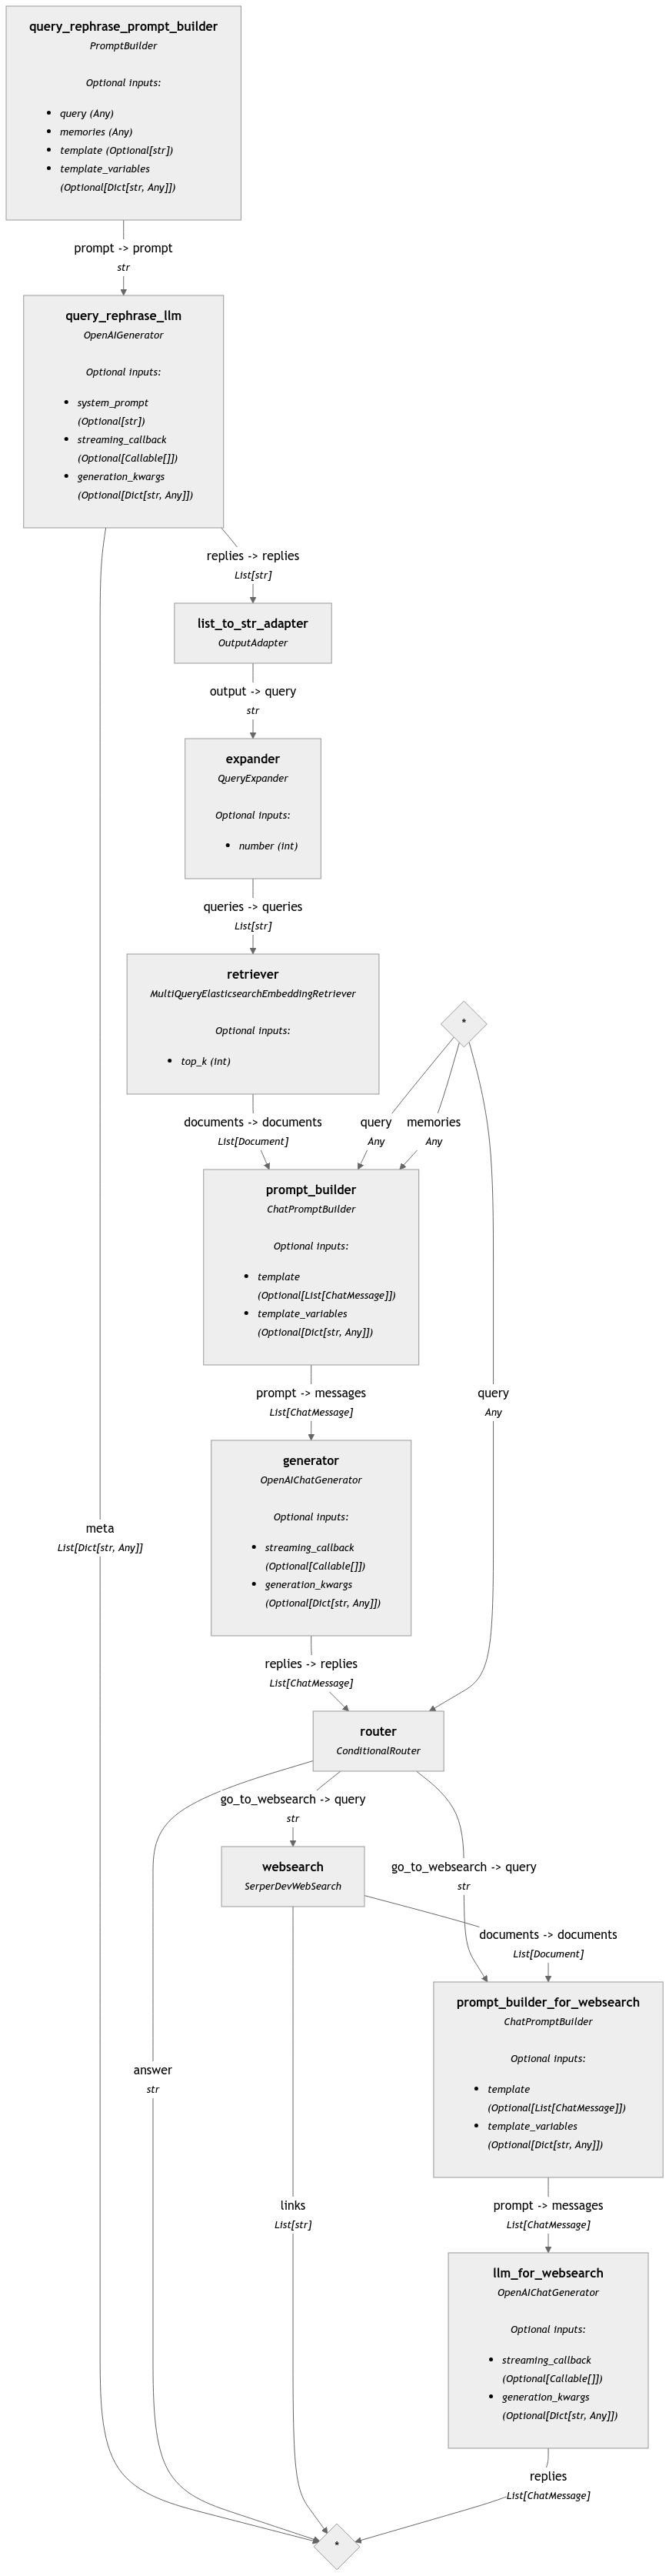

In [14]:
chat_agent.show()

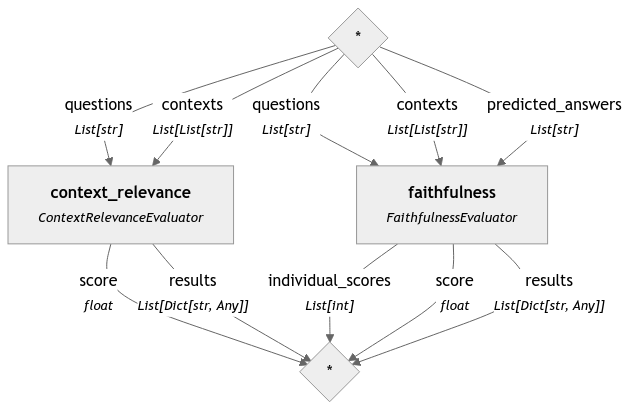

In [21]:
eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar=True, raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar = True, raise_on_failure=False))

eval_pipeline.show()

In [ ]:
messages = []
template = [system_message, user_message]
template_web = [system_message_for_web, prompt_for_websearch]

questions = []
retrieved_documents = []
predicted_answers = []
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    print(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    response = chat_agent.run({"query_rephrase_prompt_builder": {"query": user_input, "memories":messages}, 
                               "prompt_builder": {"template":template, "query": user_input, "memories":messages},
                               "router": {"query": user_input},
                               "prompt_builder_for_websearch": {"template":template_web,}},
                                include_outputs_from={"expander", "generator", "router", "retriever"})
    if response['generator']['replies'][0].content != 'no_answer':
        messages.append(ChatMessage.from_user(user_input))
        messages.extend(response['generator']['replies'])
        questions.append(user_input)
        retrieved_documents.append(response['retriever']['documents'])
        predicted_answers.append(response["generator"]["replies"][0])
        print(response['generator']['replies'][0].content)
        if len(questions)%5==0:
            eval_pipeline_results = eval_pipeline.run(
                {"context_relevance": {"questions": questions, "contexts": retrieved_documents},
                 "faithfulness": {"questions": questions, "contexts": retrieved_documents, "predicted_answers": predicted_answers},})
            results = {"context_relevance": eval_pipeline_results['context_relevance'],
                        "faithfulness": eval_pipeline_results['faithfulness'],}
            inputs = {'questions': questions, 'contexts': retrieved_documents, 'predicted_answers': predicted_answers}
            eval_results = EvaluationRunResult(run_name="rag_eval", inputs=inputs, results=results)
            eval_results.score_report().to_csv("evaluation_reports/evaluation_report_overall_score.csv")
            eval_results.to_pandas().to_csv("evaluation_reports/evaluation_report_case_by_case.csv")
    else:
        messages.append(ChatMessage.from_user(user_input))
        messages.extend(response['llm_for_websearch']['replies'])
        print(response['llm_for_websearch']['replies'][0].content)






Who is Tolkien?
{'llm': {'replies': ['["J.R.R. Tolkien biography", "works of J.R.R. Tolkien", "J.R.R. Tolkien contributions to literature", "life of J.R.R. Tolkien", "J.R.R. Tolkien and The Lord of the Rings"]'], 'meta': [{'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 49, 'prompt_tokens': 277, 'total_tokens': 326, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]}}


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s]


John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.
What did Tolkien write?
{'llm': {'replies': ['["Tolkien\'s literary works", "books written by J.R.R. Tolkien", "Tolkien\'s contributions to fantasy literature", "major stories by Tolkien", "Tolkien\'s published novels and stories"]'], 'meta': [{'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 41, 'prompt_tokens': 275, 'total_tokens': 316, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]}}


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


Tolkien wrote several notable works, including The Hobbit and The Lord of the Rings, as well as essays and letters discussing his creative process and the philosophical foundations of his work.


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Which is the 'The Hobbit' plot?
{'llm': {'replies': ['["summary of \'The Hobbit\'", "\'The Hobbit\' storyline", "overview of \'The Hobbit\'", "major events in \'The Hobbit\'", "themes in \'The Hobbit\'"]'], 'meta': [{'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 36, 'prompt_tokens': 279, 'total_tokens': 315, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]}}


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


The Hobbit follows Bilbo Baggins, a hobbit who embarks on a thrilling adventure with a group of dwarves and the wizard Gandalf.
Tell me somthing about 'The Lord of the Rings
{'llm': {'replies': ['["overview of The Lord of the Rings", "summary of The Lord of the Rings plot", "themes in The Lord of the Rings", "characters from The Lord of the Rings", "impact of The Lord of the Rings on literature"]'], 'meta': [{'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 48, 'prompt_tokens': 281, 'total_tokens': 329, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]}}


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


The Lord of the Rings, published in three volumes between 1954 and 1955, follows the journey of Frodo Baggins and his companions as they set out to destroy the One Ring, a powerful and corrupting artifact.


 25%|██▌       | 1/4 [00:05<00:16,  5.54s/it]


KeyboardInterrupt: 

In [19]:
response

{'query_rephrase_llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 5,
     'prompt_tokens': 105,
     'total_tokens': 110,
     'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'websearch': {'links': ['https://en.wikipedia.org/wiki/Shakira',
   'https://www.biography.com/musicians/shakira',
   'https://www.floridamusictours.com/musicians/shakira/',
   'https://www.donquijote.org/colombian-culture/traditions/shakira/',
   'https://www.billboard.com/artist/shakira/',
   'https://colombia.co/en/colombia-country/famous-people-from-colombia/couple-facts-didnt-know-shakira',
   'https://www.instagram.com/goodmorningamerica/p/CzwTISOM6O4/?hl=en',
   'https://thevogue.com/artists/shakira-2/',
   'https://www.rollingstone.com/t

In [ ]:
messages

[ChatMessage(content='Who is Tolkien?', role=<ChatRole.USER: 'user'>, name=None, meta={}),
 ChatMessage(content='Tolkien, or John Ronald Reuel Tolkien, was a renowned author best known for his contributions to high fantasy literature, born on January 3, 1892, in Bloemfontein, South Africa.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 43, 'prompt_tokens': 192, 'total_tokens': 235, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=0, reasoning_tokens=0, accepted_prediction_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}),
 ChatMessage(content='Tell me about him', role=<ChatRole.USER: 'user'>, name=None, meta={}),
 ChatMessage(content='J.R.R. Tolkien was a renowned author, best known for his high fantasy works, particularly *The Hobbit* and *The Lord of the Rings*. He was born on Januar

In [ ]:
predicted_answers = []
retrieved_context = []

for question in questions: # loops over questions
  result = rag.run({"query_embedder":{"text":question}, "prompt_builder":{"query": question}}, include_outputs_from={"retriever"})
  predicted_answers.append(result["generator"]["replies"][0])
  retrieved_context.append(result["retriever"]["documents"])